# First Trial with Random Forest

Generally, Rondom Forest Regressor gives good results when we tune it well. So, to find simple baseline model, I will use RandomForestRegressor in this notebook. Also, feature importance for model can be found in this notebook. 

Our metric for this project is weighted mean absolute error (WMAE):

![title](metric.png)

where

- n is the number of rows
- ŷ i is the predicted sales
- yi is the actual sales
- wi are weights. w = 5 if the week is a holiday week, 1 otherwise

With this metric, the error at holiday weeks has 5 times weight more than normal weeks. So, it is more important to predict sales at holiday weeks accurately.
All results for trails can be found at the end of this notebook.

In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

# For date-time
from datetime import datetime
from datetime import timedelta
import math

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor

In [2]:
pd.options.display.max_columns=100 # to see columns 

In [3]:
df = pd.read_csv('clean_data.csv')

In [4]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

# Encoding the Data 

For preprocessing our data, I will change holidays boolean values to 0-1 and replace type of the stores from A, B, C to 1, 2, 3. 

In [6]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [7]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [8]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [9]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [10]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [11]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

In [12]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [13]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

# Observation of Interactions between Features

Firstly, i will drop divided holiday columns from my data and try without them. To keep my encoded data safe, I assigned my dataframe to new one and I will use for this. 

In [14]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

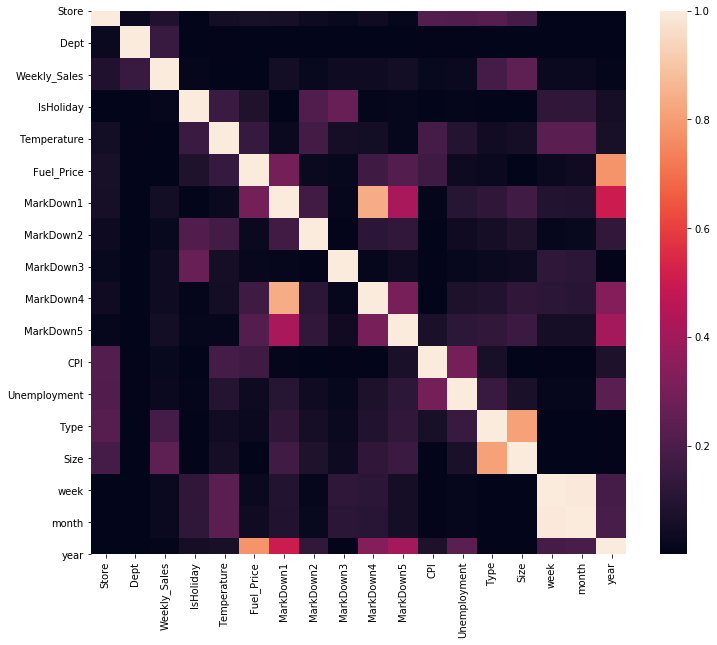

In [16]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

In [17]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

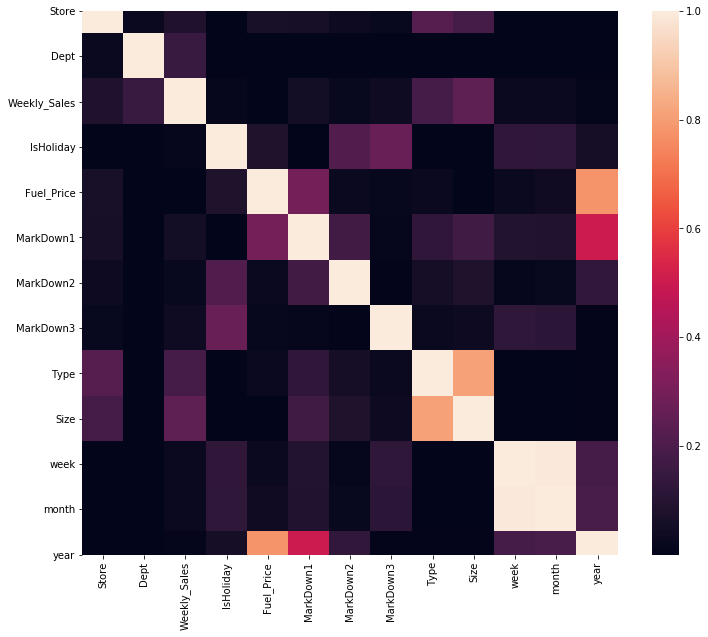

In [18]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [19]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

# Creating Train-Test Splits

Our date column has continuos values, to keep the date features continue, I will not take random splitting. so, I split data manually according to 70%.

In [20]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [32]:
X = df_new[used_cols] # to keep train and test X values together

We have enough information in our date such as week of the year. So, I drop date columns.

In [21]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

# Metric Definition Function

Our metric is not calculated as default from ready models. It is weighed error so, I will use function below to calculate it.

In [23]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

# Random Forest Regressor

To tune the regressor, I can use gridsearch but it takes too much time for this type of data which has many rows and columns. So, I choose regressor parameters manually. I changed the parameters each time and try to find the best result.

In [25]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()

#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [29]:
wmae_test(y_test, y_pred_test)

5850.444413125214

For the first trial, my weighted error is around 5850.

# To See Feature Importance

In [37]:
X = X.drop(['Date'], axis=1) #dropping date column from X

Below code cell was taken from our instructor Bryan Arnold's notebook. I changed the code according to my data and see the plot.

Feature ranking:
1. feature 1 (0.732822)
2. feature 8 (0.110390)
3. feature 0 (0.054027)
4. feature 7 (0.038210)
5. feature 9 (0.021277)
6. feature 3 (0.018402)
7. feature 10 (0.009446)
8. feature 6 (0.005523)
9. feature 4 (0.003413)
10. feature 5 (0.002776)
11. feature 2 (0.002246)
12. feature 11 (0.001467)


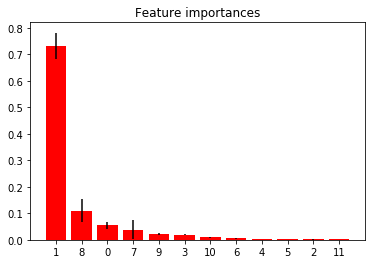

In [40]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

After looking feature importance, I dropped least important 3-4 features and tried the model. I found the best result when I dropped month column which is highly correlated with week.

In [43]:
X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

## Model Again without Month

In [44]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [46]:
wmae_test(y_test, y_pred_test)

5494.419090545123

It gives better results than baseline.

# Model with Whole Data

Now, I want to make sure that my model will learn from the columns which I dropped or not. So, I will apply my model to whole encoded data again.

In [49]:
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [71]:
X_enc = df_encoded[used_cols1] # to get together train,test splits

In [74]:
X_enc = X_enc.drop(['Date'], axis=1) #dropping date column for whole X

In [53]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [54]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [55]:
wmae_test(y_test_enc, y_pred_test_enc)

2450.1012493925496

We found better results for whole data, it means our model can learn from columns which I dropped before.

# Feature Importance for Whole Encoded Dataset

Feature ranking:
1. feature 1 (0.743136)
2. feature 13 (0.075801)
3. feature 12 (0.043810)
4. feature 0 (0.031172)
5. feature 10 (0.028007)
6. feature 11 (0.017039)
7. feature 18 (0.012315)
8. feature 3 (0.011079)
9. feature 4 (0.009879)
10. feature 19 (0.005534)
11. feature 7 (0.004481)
12. feature 9 (0.003979)
13. feature 5 (0.003461)
14. feature 8 (0.003315)
15. feature 6 (0.002381)
16. feature 16 (0.001363)
17. feature 20 (0.001200)
18. feature 2 (0.000879)
19. feature 17 (0.000597)
20. feature 14 (0.000290)
21. feature 15 (0.000283)


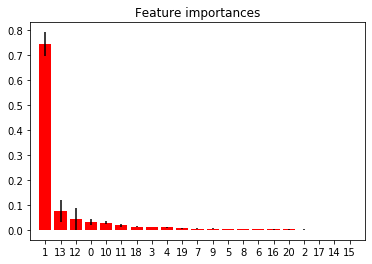

In [75]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

According to feature importance, I dropped some columns from whole set and try my model again.

In [77]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_col, axis=1, inplace=True)

# Model According to Feature Importance

In [78]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [98]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [101]:
pipe.score(X_test_enc1,y_test_enc1)

0.7397036882771106

In [99]:
wmae_test(y_test_enc1, y_pred_test_enc)

1801.5211888667177

I found best results with doing feature selection from whole encoded dataset.

# Model with Dropping Month Column

With the same dateset before, I try to model again without month column. 

In [113]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [114]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [118]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [119]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [120]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [121]:
pipe.score(X_test_enc2,y_test_enc2)

0.7040151411780626

In [122]:
wmae_test(y_test_enc2, y_pred_test_enc)

2093.074731200826

It did not give better results than before.

In [125]:
df_results = pd.DataFrame(columns=["Model", "Info",'WMAE']) # result df for showing results together

In [128]:
# writing results to df
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'w/out divided holiday columns' , 
       'WMAE' : 5850}, ignore_index=True)

In [127]:
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'w/out month column' , 
       'WMAE' : 5494}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data' , 
       'WMAE' : 2450}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data with feature selection' , 
       'WMAE' : 1801}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data with feature selection w/out month' , 
       'WMAE' : 2093}, ignore_index=True)

In [129]:
df_results

,Model,Info,WMAE
0,RandomForestRegressor,w/out divided holiday columns,5850
1,RandomForestRegressor,w/out month column,5494
2,RandomForestRegressor,whole data,2450
3,RandomForestRegressor,whole data with feature selection,1801
4,RandomForestRegressor,whole data with feature selection w/out month,2093
5,RandomForestRegressor,w/out divided holiday columns,5850


The best results belongs to whole data set with feature selection. Now, I will try time series models in new notebook.